In [1]:
# imports
import snntorch as snn
from snntorch import spikeplot as splt
from snntorch import spikegen

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np
import itertools

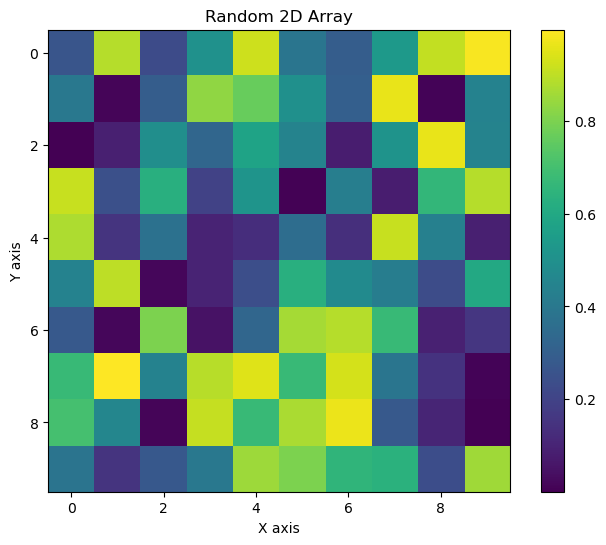

In [2]:
import torch   
import torch.nn as nn 
import torch.nn.functional as F   
import numpy as np
import matplotlib.pyplot as plt
import os
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
from scipy import io
import itertools
import math
import datetime
import wandb
import pickle
import json
import time
import sys
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from scipy.optimize import linear_sum_assignment
from snntorch import spikegen


# my module import
from modules import *

# modules 폴더에 새모듈.py 만들면
# modules/__init__py 파일에 form .새모듈 import * 하셈
# 그리고 새모듈.py에서 from modules.새모듈 import * 하셈

In [3]:
for seed in range(5):
    seed_assign(seed)

    # dataloader arguments
    batch_size = 128
    data_path='/data2'

    dtype = torch.float
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")


    # Define a transform
    transform = transforms.Compose([
                transforms.Resize((28, 28)),
                transforms.Grayscale(),
                transforms.ToTensor(),
                transforms.Normalize((0,), (1,))])

    mnist_train = datasets.MNIST(data_path, train=True, download=True, transform=transform)
    mnist_test = datasets.MNIST(data_path, train=False, download=True, transform=transform)

    # Create DataLoaders
    train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, drop_last=True)
    test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True, drop_last=True)

    # Network Architecture
    num_inputs = 28*28
    num_hidden = 1000
    num_outputs = 10

    # Temporal Dynamics
    num_steps = 25
    beta = 0.95

    # Define Network
    class Net(nn.Module):
        def __init__(self):
            super().__init__()

            # Initialize layers
            self.fc1 = nn.Linear(num_inputs, num_hidden)
            self.lif1 = snn.Leaky(beta=beta)
            self.fc2 = nn.Linear(num_hidden, num_outputs)
            self.lif2 = snn.Leaky(beta=beta)

        def forward(self, x):

            # Initialize hidden states at t=0
            mem1 = self.lif1.init_leaky()
            mem2 = self.lif2.init_leaky()

            # Record the final layer
            spk2_rec = []
            mem2_rec = []

            for step in range(num_steps):
                cur1 = self.fc1(x)
                spk1, mem1 = self.lif1(cur1, mem1)
                cur2 = self.fc2(spk1)
                spk2, mem2 = self.lif2(cur2, mem2)
                spk2_rec.append(spk2)
                mem2_rec.append(mem2)

            return torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)

    # Load the network onto CUDA if available
    net = Net().to(device)


    # pass data into the network, sum the spikes over time
    # and compare the neuron with the highest number of spikes
    # with the target

    def print_batch_accuracy(data, targets, train=False):
        output, _ = net(data.view(batch_size, -1))
        _, idx = output.sum(dim=0).max(1)
        acc = np.mean((targets == idx).detach().cpu().numpy())

        # if train:
        #     print(f"Train set accuracy for a single minibatch: {acc*100:.2f}%")
        # else:
        #     print(f"Test set accuracy for a single minibatch: {acc*100:.2f}%")


    loss = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=5e-4, betas=(0.9, 0.999))

    data, targets = next(iter(train_loader))
    data = data.to(device)
    targets = targets.to(device)

    spk_rec, mem_rec = net(data.view(batch_size, -1))
    # print(mem_rec.size())

    # initialize the total loss value
    loss_val = torch.zeros((1), dtype=dtype, device=device)

    # sum loss at every step
    for step in range(num_steps):
        loss_val += loss(mem_rec[step], targets)

    # clear previously stored gradients
    optimizer.zero_grad()

    # calculate the gradients
    loss_val.backward()

    # weight update
    optimizer.step()

    # calculate new network outputs using the same data
    spk_rec, mem_rec = net(data.view(batch_size, -1))

    # initialize the total loss value
    loss_val = torch.zeros((1), dtype=dtype, device=device)

    # sum loss at every step
    for step in range(num_steps):
        loss_val += loss(mem_rec[step], targets)


    num_epochs = 10
    loss_hist = []
    test_loss_hist = []
    counter = 0

    best_val = 0
    # Outer training loop
    for epoch in range(num_epochs):
        iter_counter = 0
        train_batch = iter(train_loader)

        # Minibatch training loop
        for data, targets in train_batch:
            data = data.to(device)
            targets = targets.to(device)

            # forward pass
            net.train()
            spk_rec, mem_rec = net(data.view(batch_size, -1))

            # initialize the loss & sum over time
            loss_val = torch.zeros((1), dtype=dtype, device=device)
            for step in range(num_steps):
                loss_val += loss(mem_rec[step], targets)

            # Gradient calculation + weight update
            optimizer.zero_grad()
            loss_val.backward()
            optimizer.step()

            # Store loss history for future plotting
            loss_hist.append(loss_val.item())

        total = 0
        correct = 0
        with torch.no_grad():
            net.eval()
            for data, targets in test_loader:
                data = data.to(device)
                targets = targets.to(device)

                # forward pass
                test_spk, _ = net(data.view(data.size(0), -1))

                # calculate total accuracy
                _, predicted = test_spk.sum(dim=0).max(1)
                total += targets.size(0)
                correct += (predicted == targets).sum().item()
            best_val = max(correct / total, best_val)
            print(f"Test Set Accuracy: {100 * correct / total:.2f}%, Best Accuracy: {100 * best_val:.2f}%")


Test Set Accuracy: 92.80%, Best Accuracy: 92.80%
Test Set Accuracy: 95.15%, Best Accuracy: 95.15%
Test Set Accuracy: 96.47%, Best Accuracy: 96.47%
Test Set Accuracy: 96.25%, Best Accuracy: 96.47%
Test Set Accuracy: 97.28%, Best Accuracy: 97.28%
Test Set Accuracy: 96.23%, Best Accuracy: 97.28%
Test Set Accuracy: 96.21%, Best Accuracy: 97.28%
Test Set Accuracy: 96.86%, Best Accuracy: 97.28%
Test Set Accuracy: 96.27%, Best Accuracy: 97.28%
Test Set Accuracy: 96.31%, Best Accuracy: 97.28%
Test Set Accuracy: 93.72%, Best Accuracy: 93.72%
Test Set Accuracy: 96.20%, Best Accuracy: 96.20%
Test Set Accuracy: 96.95%, Best Accuracy: 96.95%
Test Set Accuracy: 97.29%, Best Accuracy: 97.29%
Test Set Accuracy: 96.69%, Best Accuracy: 97.29%
Test Set Accuracy: 97.17%, Best Accuracy: 97.29%
Test Set Accuracy: 97.11%, Best Accuracy: 97.29%
Test Set Accuracy: 97.10%, Best Accuracy: 97.29%
Test Set Accuracy: 97.25%, Best Accuracy: 97.29%
Test Set Accuracy: 96.79%, Best Accuracy: 97.29%
Test Set Accuracy: 9

이거 bptt on